In [1]:
import wod_predictor
from wod_predictor.data_loader import DataLoader
from wod_predictor.splitter import DataSplitter
from wod_predictor.preprocessor import DataPreprocessor 
from wod_predictor.modeling import RandomForestModel

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = wod_predictor.__path__[0].replace("wod_predictor", "Data")
loader = DataLoader(root_path = data_path, objects= ['open_results','descriptions','benchmark_stats',  'athlete_info'])
data = loader.load()

In [4]:
splitter = DataSplitter(sample = 20000, test_ratio=  0.2, test_filter='23.*')
train_data, test_data = splitter.split(data)

In [5]:
splitter = DataSplitter(sample = 20000, test_ratio = 0.2, test_filter='23.*')
val_test_splitter = DataSplitter(test_ratio = 0.5)
train_data, val_test_data = splitter.split(data)
val_data, test_data = val_test_splitter.split(val_test_data)

In [15]:
# Example using MinMaxScaler
preprocessing_config = {
    'open_results':
    {
        'scale_up': True,
        'scale_args': {
            "method": "general",
            "scaler_name": "MinMaxScaler"
        },
        'allow_modified' : False
    },
    'benchmark_stats':{
        'remove_outliers': True,
        'missing_method':'zero',
        'drop_missing_threshold': 0.9,
        'scale_args': {
            "method": "general",
            "scaler_name": "MinMaxScaler",
        }
        # 'neighbors': 5,
    },
    'athlete_info':{}
}
preprocessor = DataPreprocessor(config=preprocessing_config)
preprocessor.fit(data=train_data)


In [16]:
train_preprocessed = preprocessor.transform(data=train_data)

Converted height to height in imperial units
Converted weight to weight in imperial units


In [17]:
test_preprocessed = preprocessor.transform(data=test_data)

Converted height to height in imperial units
Converted weight to weight in imperial units


In [18]:
config = {}
rf_modeler = RandomForestModel(config = config, n_estimators = 10)
rf_modeler.fit(X = train_preprocessed['X'], y = train_preprocessed['y'])
rf_modeler.predict(X = test_preprocessed['X'])
rf_modeler.show_results(y_test = test_preprocessed['y'], meta_data = test_preprocessed['meta_data'])

Mean Absolute Error: 0.04
Mean Absolute Percentage Error: 305687713511.97


,y_test_mean,y_pred_mean,error_mean,error_percentage
23.1,185.334511,185.218599,8.082113,4.360825
23.1_scaled,215.666667,229.955556,22.900000,10.618238
23.2A,132.416208,131.971370,11.265231,8.507441
23.2B,206.817909,207.200448,18.756320,9.069002
23.3,28.379241,25.793835,10.259939,36.152971
23.3_scaled,10.169444,10.984909,1.385630,13.625422


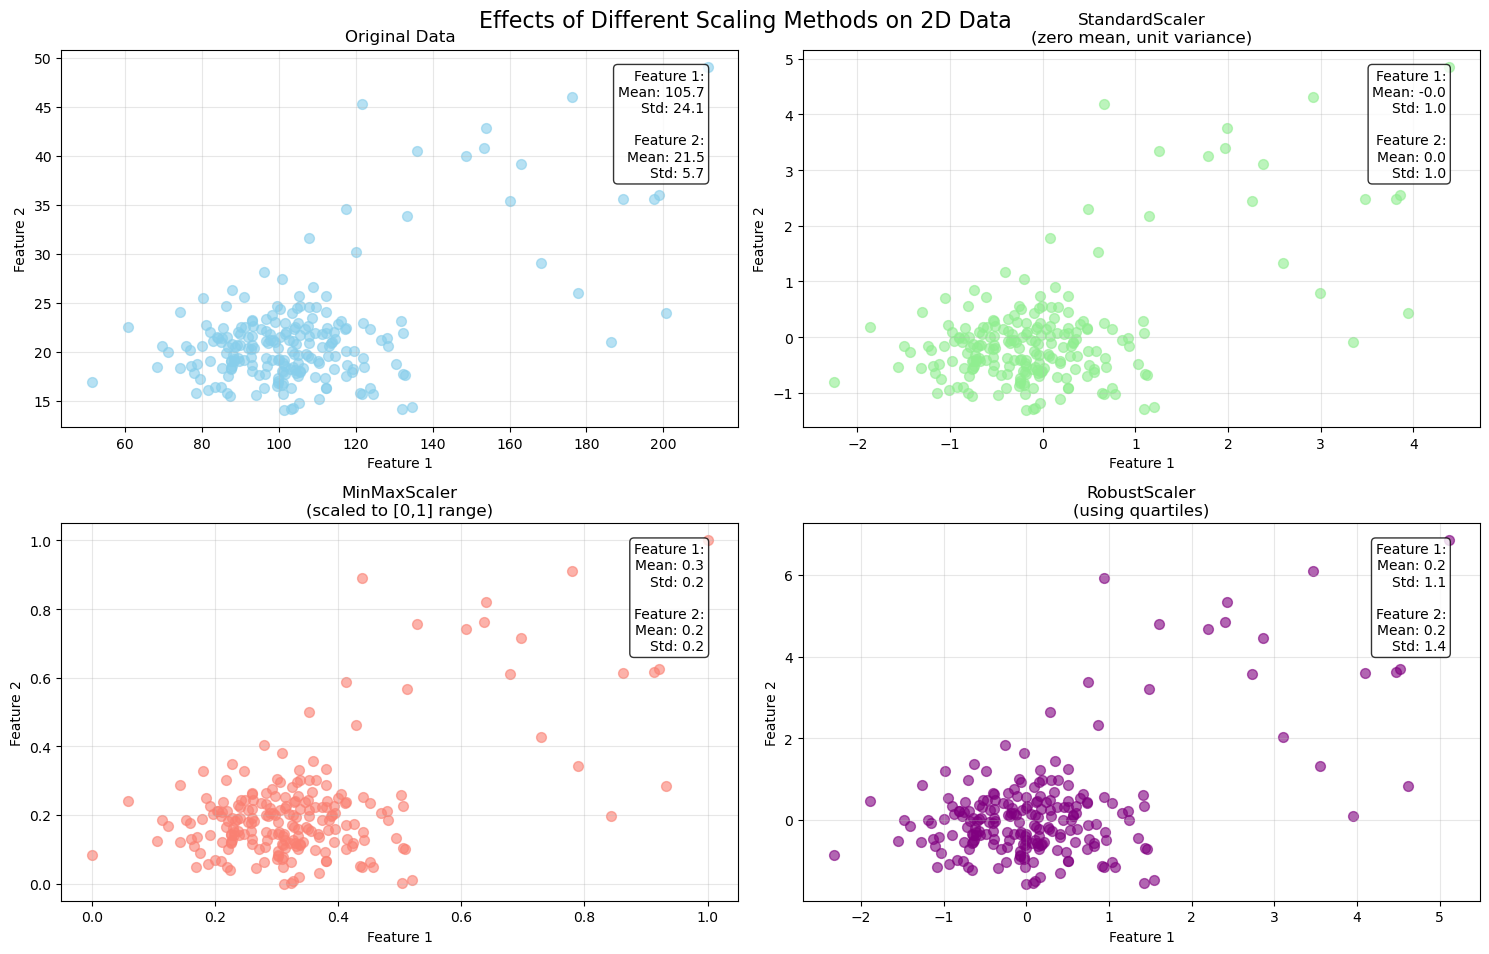

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
np.random.seed(42)

# Generate 2D sample data with different scales and outliers
n_samples = 200
# Create two correlated features with different scales
X = np.random.normal(0, 1, (n_samples, 2))
X[:, 0] = X[:, 0] * 15 + 100  # First feature: mean=100, larger scale
X[:, 1] = X[:, 1] * 3 + 20    # Second feature: mean=20, smaller scale

# Add some outliers
outliers = np.random.normal(0, 1, (20, 2))
outliers[:, 0] = outliers[:, 0] * 25 + 160
outliers[:, 1] = outliers[:, 1] * 8 + 35
X = np.vstack([X, outliers])

# Apply different scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

X_standard = standard_scaler.fit_transform(X)
X_minmax = minmax_scaler.fit_transform(X)
X_robust = robust_scaler.fit_transform(X)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Effects of Different Scaling Methods on 2D Data', fontsize=16, y=0.95)

# Plot settings
plot_settings = dict(alpha=0.6, s=50)

# Original Data
ax = axes[0, 0]
scatter = ax.scatter(X[:, 0], X[:, 1], c='skyblue', **plot_settings)
ax.set_title('Original Data')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid(True, alpha=0.3)

# Add stats box
stats_original = f'Feature 1:\nMean: {X[:, 0].mean():.1f}\nStd: {X[:, 0].std():.1f}\n\nFeature 2:\nMean: {X[:, 1].mean():.1f}\nStd: {X[:, 1].std():.1f}'
ax.text(0.95, 0.95, stats_original, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# StandardScaler
ax = axes[0, 1]
scatter = ax.scatter(X_standard[:, 0], X_standard[:, 1], c='lightgreen', **plot_settings)
ax.set_title('StandardScaler\n(zero mean, unit variance)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid(True, alpha=0.3)

stats_standard = f'Feature 1:\nMean: {X_standard[:, 0].mean():.1f}\nStd: {X_standard[:, 0].std():.1f}\n\nFeature 2:\nMean: {X_standard[:, 1].mean():.1f}\nStd: {X_standard[:, 1].std():.1f}'
ax.text(0.95, 0.95, stats_standard, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# MinMaxScaler
ax = axes[1, 0]
scatter = ax.scatter(X_minmax[:, 0], X_minmax[:, 1], c='salmon', **plot_settings)
ax.set_title('MinMaxScaler\n(scaled to [0,1] range)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid(True, alpha=0.3)

stats_minmax = f'Feature 1:\nMean: {X_minmax[:, 0].mean():.1f}\nStd: {X_minmax[:, 0].std():.1f}\n\nFeature 2:\nMean: {X_minmax[:, 1].mean():.1f}\nStd: {X_minmax[:, 1].std():.1f}'
ax.text(0.95, 0.95, stats_minmax, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# RobustScaler
ax = axes[1, 1]
scatter = ax.scatter(X_robust[:, 0], X_robust[:, 1], c='purple', **plot_settings)
ax.set_title('RobustScaler\n(using quartiles)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid(True, alpha=0.3)

stats_robust = f'Feature 1:\nMean: {X_robust[:, 0].mean():.1f}\nStd: {X_robust[:, 0].std():.1f}\n\nFeature 2:\nMean: {X_robust[:, 1].mean():.1f}\nStd: {X_robust[:, 1].std():.1f}'
ax.text(0.95, 0.95, stats_robust, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()